In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from bnpTools.analysis import kmean_analysis
from bnpTools.plotting import addColorBar
from skimage.measure import find_contours
from scipy.ndimage import binary_fill_holes
import matplotlib
from bnpTools.plotting import addScaleBar
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift

In [2]:
def getContourMask(d, d_binary, vmin = -0.15, vmax = 0.15, cmap = 'RdBu', num_pix = 400, sel_c = None, level = 0.8, color=None, loc = None, savefig = False, fname = None):
    contours = find_contours(d_binary, level = 0.8, fully_connected = 'high')
    # contour = contours[0]
    fig, ax = plt.subplots(figsize=(4,4))
    img = ax.imshow(d, cmap=cmap, vmax = vmax, vmin = vmin)
    cmap = plt.cm.get_cmap('gray')
    for i, contour in enumerate(contours):
        if len(contour) > num_pix:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2, 
                    color = cmap(1/i if i > 0 else 0) if color is None else color, 
                    label='%d'%i if color is None else 'Contour')
            sel_c = i if sel_c is None else sel_c
    ax.set_xticks([])
    ax.set_yticks([])
    addColorBar(fig, img, ax)
    plt.tight_layout()
    ax.legend(loc='best' if loc is None else loc)
    # plt.savefig('./xrfDiff_contour_2.png', dpi = 300)

    # create mask using contour (iodine rich)
    contour = contours[sel_c]
    d_mask = np.zeros_like(d, dtype='bool')
    d_mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
    d_mask = binary_fill_holes(d_mask)
    
    if savefig:
        if fname is None: print('File not save. Require a valid file name')
        else: fig.savefig(fname, dpi = 300)
    return contour, d_mask

In [3]:
# create np array for I:Pb or Br:Pb difference
def getXRFdifference(d, mask, refidx=0):
    n, w, h = d.shape
    print(n,w,h)
    diff_data = np.zeros((n-1, w, h))
    ref = d[refidx]
    for i in range(n):
        if i != refidx:
            d_diff = (d[i]-ref) * mask
            d_diff[np.isnan(d_diff)] = 0
            diff_data[i if i < refidx else (i-1),:,:] = d_diff
    return diff_data

In [4]:
def plotElmRow(fig, axes, elmdata, ss, contour=None, cmap='RdBu', vmin=None, vmax = None, colorbar=False, xpos = 0.3, ypos=0.95, cbarlabel=None, labelpad=0, origin='upper'):
    for ax_, i in zip(axes, elmdata):
        img = ax_.imshow(i, cmap=cmap, vmin = vmin, vmax = vmax, origin=origin)
        if contour is not None:
            ax_.plot(contour[:, 1], contour[:, 0], linewidth=1, color = 'k')
        addScaleBar(ax_, i, ss, xpos = xpos, ypos=ypos, color='k')
        ax_.set_xticks([])
        ax_.set_yticks([])
        ax_.axis('equal')
        if colorbar:
            cb = addColorBar(fig, img, ax_)
            cb.remove()
    if colorbar:
        cb = addColorBar(fig, img, ax_)
        if cbarlabel is not None:
            cb.set_label('$\delta (%s)$'%(cbarlabel), fontsize=11, labelpad=labelpad)

In [5]:
def plotSingleElm(fig, ax, elmdata, ss:'stepsize', cmap='inferno', vmin = 0, vmax=None, xpos = 0.3, ypos = 0.95, cbarlabel=None, labelpad=0, origin='upper'):
    img = ax.imshow(elmdata, cmap = cmap, vmin = vmin, vmax = vmax, origin=origin)
    addScaleBar(ax, elmdata, ss, xpos = xpos, ypos = ypos)
    cbar = addColorBar(fig, img, ax)
    cbar.set_ticks([vmin, vmax])
    if cbarlabel is not None:
        cbar.set_label('%s'%(cbarlabel), fontsize=11, labelpad = labelpad)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('equal')

In [6]:
def addScaleBar(ax, d:'data', ss:'stepsize', sbar:'um' = 5, xpos:'% ratio of shape[1]'=0.3, ypos:'% ratio of shape[0]'=0.95, color='w'):
    ax.errorbar(d.shape[1]*xpos, d.shape[0]*ypos, xerr = sbar / ss / 2, color = color, lw = 3)

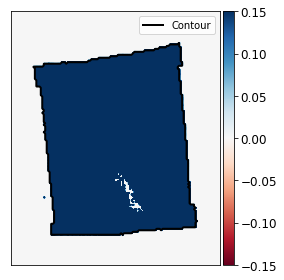

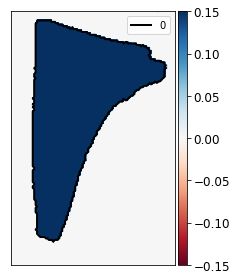

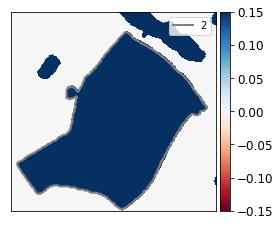

In [7]:
## load processd data
with open('n2_sm1_roi2_molarRatio_2idd.dat', 'r') as f:
    n2cry_2 = json.load(f)
with open('n3_sm3_roi1_molarRatio_bnp.dat', 'r') as f:
    n3cry = json.load(f)
with open('n1_roi1_molarRatio_bnp_1.dat', 'r') as f:
    n1cry = json.load(f)

n1ipb = np.asarray(n1cry['I:Pb'],dtype='float32')
n1brpb = np.asarray(n1cry['Br:Pb'],dtype='float32')
n2ipb_2 = np.asarray(n2cry_2['I:Pb'],dtype='float32')
n2brpb_2 = np.asarray(n2cry_2['Br:Pb'],dtype='float32')
n3ipb = np.asarray(n3cry['I:Pb'],dtype='float32')
n3brpb = np.asarray(n3cry['Br:Pb'],dtype='float32')

brpbmap = n1brpb[-1]
brpb_binary = brpbmap > 0.1
n1contour, n1mask = getContourMask(brpbmap, brpb_binary, num_pix = 150, color = 'k')

brpbmap_2 = n2brpb_2[-1]
brpb_binary_2 = brpbmap_2 > 0.1
n2contour_2, n2mask_2 = getContourMask(brpbmap_2, brpb_binary_2)

brpbmap = n3brpb[-1]
brpb_binary = brpbmap > 0.1
n3contour, n3mask = getContourMask(brpbmap, brpb_binary)
n3mask = n3mask

In [8]:
n1_time = np.round(np.asarray(n1cry['light_on_min'], dtype='float32'),1)
n2_time_2 = np.round(np.asarray(n2cry_2['light_on_min'], dtype='float32'),1)
n3_time = np.round(np.asarray(n3cry['light_on_min'], dtype='float32'),1)

n1ipb_diff = getXRFdifference(n1ipb, n1mask, refidx=0)
n1brpb_diff = getXRFdifference(n1brpb, n1mask, refidx=0)
n2ipb_diff_2 = getXRFdifference(n2ipb_2, n2mask_2, refidx=0)
n2brpb_diff_2 = getXRFdifference(n2brpb_2, n2mask_2, refidx=0)
n3ipb_diff = getXRFdifference(n3ipb, n3mask, refidx=0)
n3brpb_diff = getXRFdifference(n3brpb, n3mask, refidx=0)

5 171 141
5 171 141
5 176 114
5 176 114
8 190 196
8 190 196


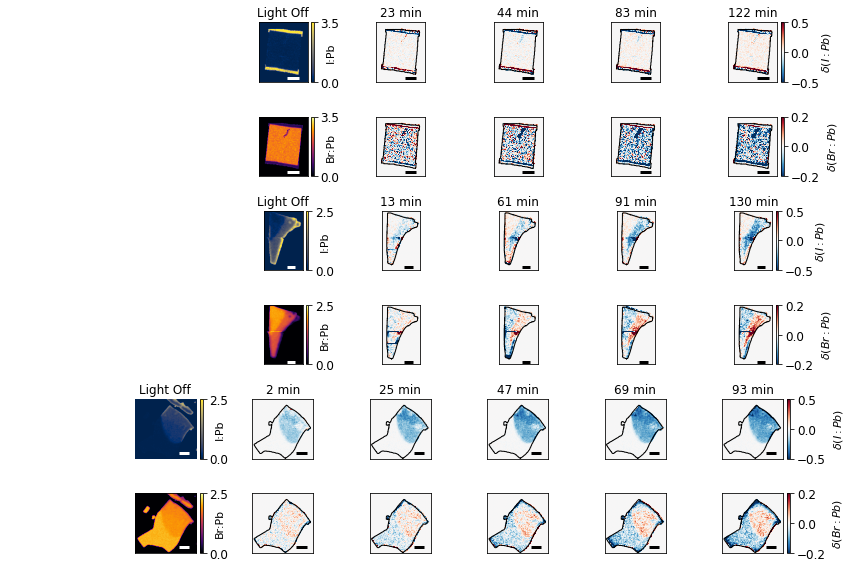

In [9]:
fig, ax = plt.subplots(6,7,figsize=(12,8))

ax_rw0 = ax[0,:].ravel()    # n = 1 I:Pb
plotSingleElm(fig, ax_rw0[2], n1ipb[0], float(n1cry['stepsize'][0]), cmap = 'cividis', vmax = 3.5, xpos = 0.7, ypos = 0.06, cbarlabel='I:Pb', labelpad=-14, origin='lower')
plotElmRow(fig, ax_rw0[3:], n1ipb_diff, float(n1cry['stepsize'][0]), contour=n1contour, cmap = 'RdBu_r', vmin = -0.5, vmax = 0.5, xpos = 0.7, ypos = 0.06, colorbar=True, cbarlabel='I:Pb', labelpad=0, origin='lower')
for ax_, t_ in zip(ax_rw0[2:], n1_time): ax_.set_title('Light Off' if t_<0 else '%d min'%t_)

ax_rw1 = ax[1,:].ravel()    # n = 1 Br:Pb
plotSingleElm(fig, ax_rw1[2], n1brpb[0], float(n1cry['stepsize'][0]), cmap = 'inferno', vmax = 3.5, xpos = 0.7, ypos = 0.06, cbarlabel='Br:Pb', labelpad=-14, origin='lower')
plotElmRow(fig, ax_rw1[3:], n1brpb_diff, float(n1cry['stepsize'][0]), contour=n1contour, cmap = 'RdBu_r', vmin = -0.2, vmax = 0.2, xpos = 0.7, ypos = 0.06, colorbar=True, cbarlabel='Br:Pb', labelpad=6, origin='lower')

ax_rw2 = ax[2,:].ravel()    # n = 2 I:Pb
plotSingleElm(fig, ax_rw2[2], n2ipb_2[0], float(n2cry_2['stepsize'][0]), cmap = 'cividis', vmax = 2.5, xpos = 0.7, ypos = 0.95, cbarlabel='I:Pb', labelpad=-14)
plotElmRow(fig, ax_rw2[3:], n2ipb_diff_2, float(n2cry_2['stepsize'][0]), contour=n2contour_2, cmap = 'RdBu_r', vmin = -0.5, vmax = 0.5, xpos = 0.7, ypos = 0.95, colorbar=True, cbarlabel='I:Pb', labelpad=0)
for ax_, t_ in zip(ax_rw2[2:], n2_time_2): ax_.set_title('Light Off' if t_<0 else '%d min'%t_)

ax_rw3 = ax[3,:].ravel()    # n = 2 Br:Pb
plotSingleElm(fig, ax_rw3[2], n2brpb_2[0], float(n2cry_2['stepsize'][0]), cmap = 'inferno', vmax = 2.5, xpos = 0.7, ypos = 0.95, cbarlabel='Br:Pb', labelpad=-14)
plotElmRow(fig, ax_rw3[3:], n2brpb_diff_2, float(n2cry_2['stepsize'][0]), contour=n2contour_2, cmap = 'RdBu_r', vmin = -0.2, vmax = 0.2, xpos = 0.7, ypos = 0.95, colorbar=True, cbarlabel='Br:Pb', labelpad=6)

ax_rw4 = ax[4,:].ravel()    # n = 3 I:Pb
plotSingleElm(fig, ax_rw4[1], n3ipb[0], float(n3cry['stepsize'][0]), cmap = 'cividis', vmax = 2.5, xpos = 0.8, ypos = 0.9, cbarlabel='I:Pb', labelpad=-14)
plotElmRow(fig, ax_rw4[2:], n3ipb_diff[0:-2,:,:], float(n3cry['stepsize'][0]), contour=n3contour, cmap = 'RdBu_r', vmin = -0.5, vmax = 0.5, xpos = 0.8, ypos = 0.9, colorbar=True, cbarlabel='I:Pb', labelpad=6)
for ax_, t_ in zip(ax_rw4[1:], n3_time): ax_.set_title('Light Off' if t_<0 else '%d min'%t_)

ax_rw5 = ax[5,:].ravel()    # n = 3 Br:Pb
plotSingleElm(fig, ax_rw5[1], n3brpb[0], float(n3cry['stepsize'][0]), cmap = 'inferno', vmax = 2.5, xpos = 0.8, ypos = 0.9,cbarlabel='Br:Pb', labelpad=-14)
plotElmRow(fig, ax_rw5[2:], n3brpb_diff[:-2], float(n3cry['stepsize'][0]), contour=n3contour, cmap = 'RdBu_r', vmin = -0.2, vmax = 0.2, xpos = 0.8, ypos = 0.9, colorbar=True, cbarlabel='Br:Pb', labelpad=5)

# turn off some axis
for i in range(6):
    axes = eval('ax_rw%d'%(i))
    if i < 5:
        for j in range(2):
            axes[j].axis('off')
    else:
        axes[0].axis('off')
plt.tight_layout()
# plt.savefig('./fig1_4-4.png', dpi = 300)

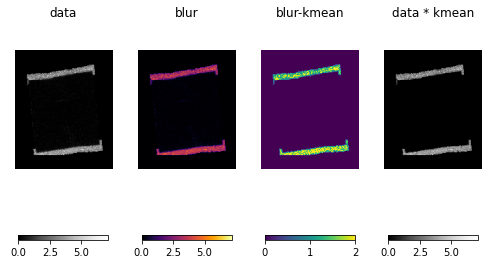

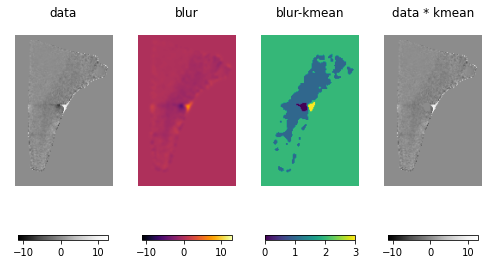

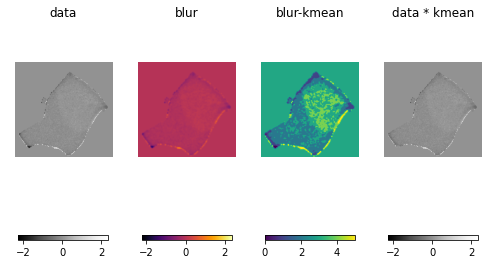

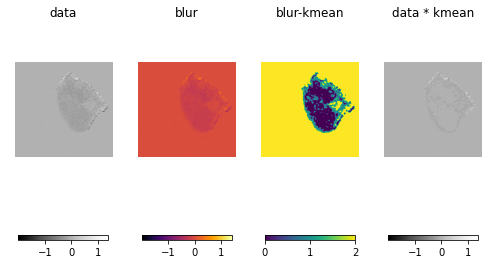

In [10]:
## n = 1, iodine rich region
n_cluster = 3
# ipb_diff_sum = np.sum(n1ipb_diff, axis=0)
ipb = n1ipb[0]
a = kmean_analysis(n_cluster, ipb, 52, plotoption=True, sigma=None)
i_poor_1 = (a[1]!=0)

## n = 2, iodine depleted region
n_cluster = 4
ipb_diff_sum = np.sum(n2ipb_diff_2, axis=0)
a = kmean_analysis(n_cluster, ipb_diff_sum, 52, plotoption=True, sigma=1.5)
i_poor_2 = (a[1]==1)
# c2_2,m2_2 = getContourMask(n2brpb_diff_2[3],i_poor_2,cmap='RdBu_r',color='k', loc='lower right', savefig=False, fname='./n=2_iodineDepleted_area.png' )

## n = 3, iodine depleted region
n_cluster = 6
n3_brpb_diff_sum = n3brpb_diff[4]
a_n3 = kmean_analysis(n_cluster, n3_brpb_diff_sum, 52, plotoption=True, sigma=1)
n3_ipb_diff = n3ipb_diff[0]
a_i_n3 = kmean_analysis(3, n3_ipb_diff, 52, plotoption=True, sigma=1)
i_poor_n3 = (a_i_n3[1]<2)
br_rich_n3 = (a_n3[1]==2)*n3mask
br_rich_n3 = ~br_rich_n3*n3mask
ibr_n3_mask = (i_poor_n3 & br_rich_n3)
# c3,m3 = getContourMask(n3brpb_diff[4],ibr_n3_mask, cmap='RdBu_r', num_pix=400, loc='best', color='k', savefig=False, fname='./n=3_iodineDepleted_area.png' )

In [11]:
# monitor change of Iodine and Br in crystal with n = 1
p_min = 1
p_max = 100 - p_min
ipb_sel_n1 = [n1ipb[i][i_poor_1>0] for i in range(n1ipb.shape[0])]
brpb_sel_n1 = [n1brpb[i][i_poor_1>0] for i in range(n1ipb.shape[0])]
n1_uI = [np.mean(np.clip(i, a_min = np.percentile(i, p_min), a_max = np.percentile(i, p_max))) for i in ipb_sel_n1]
n1_uBr = [np.mean(np.clip(i, a_min = np.percentile(i, p_min), a_max = np.percentile(i, p_max))) for i in brpb_sel_n1]

ipb_sel_n2_2 = [n2ipb_2[i][m2_2 > 0] for i in range(n2ipb_2.shape[0])]
brpb_sel_n2_2 = [n2brpb_2[i][m2_2 > 0] for i in range(n2brpb_2.shape[0])]
n2_2_uI = [np.mean(np.clip(i, a_min = np.percentile(i, p_min), a_max = np.percentile(i, p_max))) for i in ipb_sel_n2_2]
n2_2_uBr = [np.mean(np.clip(i, a_min = np.percentile(i, p_min), a_max = np.percentile(i, p_max))) for i in brpb_sel_n2_2]

ipb_sel_n3 = [n3ipb[i][m3 > 0] for i in range(n3ipb.shape[0]-2)]
brpb_sel_n3 = [n3brpb[i][m3 > 0] for i in range(n3brpb.shape[0]-2)]
n3_uI = [np.mean(np.clip(i, a_min = np.percentile(i, p_min), a_max = np.percentile(i, p_max))) for i in ipb_sel_n3]
n3_uBr = [np.mean(np.clip(i, a_min = np.percentile(i, p_min), a_max = np.percentile(i, p_max))) for i in brpb_sel_n3]

NameError: name 'm2_2' is not defined

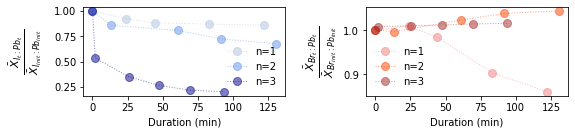

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,2),sharex = True)
ystr = ['n1_uI', 'n2_2_uI', 'n3_uI']
xstr = ['n1_time', 'n2_time_2', 'n3_time']
crylabel = ['n=1', 'n=2', 'n=3']

color = ['lightsteelblue','cornflowerblue', 'darkblue']
for idx, (y_, x_, l_, c_) in enumerate(zip(ystr, xstr, crylabel, color)):
    yval = eval(y_)
    yval = yval / yval[0]
    xval = eval(x_)
    xval[xval<0] = 0
    xval = xval if 'n3' not in x_ else xval[0:len(yval)]
    ax[0].plot(xval, yval, label = l_, marker='o', ls=':', lw=1, alpha = 0.5, color = c_, ms=8)
        
ystr = ['n1_uBr','n2_2_uBr','n3_uBr']
xstr = ['n1_time', 'n2_time_2','n3_time']
crylabel = ['n=1', 'n=2', 'n=3']
color = ['lightcoral', 'orangered', 'brown', ]
for idx, (y_, x_, l_, c_) in enumerate(zip(ystr, xstr, crylabel, color)):
    yval = eval(y_)
    yval = yval / yval[0]
    xval = eval(x_)
    xval[xval<0] = 0
    xval = xval if 'n3' not in x_ else xval[0:len(yval)]
    ax[1].plot(xval, yval, label = l_, marker='o', ls=':', lw=1, alpha = 0.5, color = c_, ms=8)

ax[0].legend(frameon=False, loc = 'best')
ax[1].legend(frameon=False, loc = 'best')

ax[0].set_xlabel('Duration (min)')
ax[1].set_xlabel('Duration (min)')
ax[0].set_ylabel(r'$\frac{\bar{X}_{I_t:Pb_t}}{\bar{X}_{I_{init}:Pb_{init}}}$', fontsize=16, labelpad=10)
ax[1].set_ylabel(r'$\frac{\bar{X}_{Br_t:Pb_t}}{\bar{X}_{Br_{init}:Pb_{init}}}$', fontsize=16)

plt.tight_layout()
# fig.savefig('./halideRedistribution_mean_2.svg', dpi = 300)